# Qiong Zhou / qzho906 / Infosys 722 Iteration4

In [2]:
#Initialization the pyspark envionment, 
#it will be named i4 and used for the assignment.
# Must be included at the beginning of each new notebook.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark as ps
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('i4').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/15 22:25:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in the data. Note that it's in the format of csv.
#Load csv file into spark and evaluate the status of it.
df = spark.read.csv("./train_strokes.csv", header = "true")
print("Raw data, there are", df.count(),"instances.")
df.printSchema()
df.columns

Raw data, there are 43400 instances.
root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: string (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: string (nullable = true)



['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

# Section 3 Data Preparation

Iteration 4 / 3.1 Data Selection

In [4]:
# step 1, row selection, keep all rows
# step 2, column selection: drop Residence_type

print("Number of Instances before selection: ",df.count())

strokeData = df.filter("stroke == 1")
nonStrokeData = df.filter("stroke == 0")

print("Number of Stroke Instances before selection: ",strokeData.count())
print("Number of Non-Stroke Instances before selection: ",nonStrokeData.count())

Number of Instances before selection:  43400
Number of Stroke Instances before selection:  783
Number of Non-Stroke Instances before selection:  42617


In [5]:
# Do column selection
print("Raw data number of Columns: ", len(df.columns))
print("Raw data Columns: ", df.columns)

selectedData = df.drop("Residence_type")

print("Selected data number of Columns: ", len(selectedData.columns))
print("Selected data Columns: ", selectedData.columns)

Raw data number of Columns:  12
Raw data Columns:  ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
Selected data number of Columns:  11
Selected data Columns:  ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


Iteration 4 / 3.2 Data Cleaning

In [6]:
#temp
print(selectedData.count())

43400


In [7]:
# Check which column has null value
#missing_status = selectedData.isNull(raw_data)
#print(missing_status.any())

In [8]:
# Remove empty values for BMI using FILL function with average BMI value

from pyspark.sql.functions import col, when
print("Number of Nulls before removal (BMI): ", selectedData.filter("bmi is null").count())
# Use your sales average to fill missing data. 
from pyspark.sql.functions import mean

# Let's collect the average. You'll notice that the collection returns the average in an interesting format.
mean_bmi = selectedData.select(mean(selectedData['bmi'])).collect()
mean_bmi = mean_bmi[0][0]
print(mean_bmi)

# And finally, fill the missing values with the mean.
selectedData = selectedData.fillna(str(mean_bmi), subset='bmi')
# selectedData = selectedData.fillna(random.choice(options), subset = "smoking_status")



#selectedData = selectedData.na.drop(subset = "bmi")

print("Number of Nulls after removal (BMI): ", selectedData.filter("bmi is null").count())

Number of Nulls before removal (BMI):  1462
28.605038390004545
Number of Nulls after removal (BMI):  0


In [9]:
# selectedData.show(n=300)

In [10]:
# from pyspark.sql.functions import col, when
# print("Number of Nulls before removal (BMI): ", selectedData.filter("bmi is null or bmi == 'N/A'").count())

# selectedData = selectedData.withColumn("bmi", when(col("bmi") == "N/A", None).otherwise(col("bmi")))
# selectedData = selectedData.na.drop(subset = "bmi")

# print("Number of Nulls after removal (BMI): ", selectedData.filter("bmi is null or bmi == 'N/A'").count())

In [11]:
import random
print("Number of Nulls before removal (smoking_status): ", selectedData.filter("smoking_status is null or smoking_status == 'Unknown'").count())

options = ['formerly smoked', 'never smoked', 'smokes']
# selectedData = selectedData.withColumn("smoking_status", when(col("smoking_status") == "Unknown", None).otherwise(col("smoking_status")))
selectedData = selectedData.dropna(subset='smoking_status')

print("Number of Nulls after removal (smoking_status): ", selectedData.filter("smoking_status is null or smoking_status == 'Unknown'").count())
print("smoking_status Values Available: ")
selectedData.select("smoking_status").distinct().show()

Number of Nulls before removal (smoking_status):  13292
Number of Nulls after removal (smoking_status):  0
smoking_status Values Available: 
+---------------+
| smoking_status|
+---------------+
|         smokes|
|   never smoked|
|formerly smoked|
+---------------+



In [12]:
# selectedData.show(n=100)

In [13]:
# Remove outliers of attributes
# Convert Schema of each attributes
from pyspark.sql.functions import col
from pyspark.sql.types import (StructField,DoubleType,StringType,IntegerType)

missing_removedData = selectedData.withColumn("bmi",col("bmi").cast(DoubleType())) \
    .withColumn("age",col("age").cast(DoubleType())) \
    .withColumn("avg_glucose_level",col("avg_glucose_level").cast(DoubleType()))
missing_removedData.printSchema()

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: string (nullable = true)



<AxesSubplot:>

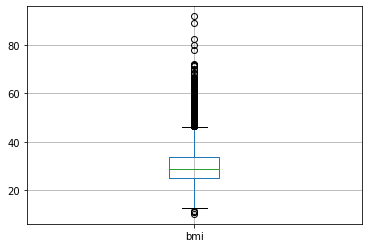

In [14]:
# BMI BMI BMI BMI BMI BMI BMI
# BEFORE ---- WITH OUTLIER BOXPLOT
import pandas as pd
elementsToCheck = "bmi"
selectedDataPd = missing_removedData.toPandas()
selectedDataPd.boxplot(column=[elementsToCheck])

In [15]:
# avg_glucose_level
# BEFORE ---- WITH OUTLIER BOXPLOT
#elementsToCheck = "avg_glucose_level"
#selectedDataPd = missing_removedData.toPandas()
#selectedDataPd.boxplot(column=[elementsToCheck])

In [16]:
# Print out the boxplot before removal
# APPLYING FILTERS
from pyspark.sql.functions import countDistinct,avg,stddev,format_number

std_bmi = missing_removedData.select(stddev("bmi"))
# std_bmi.show()
std_bmi = std_bmi.collect()
std_bmi = std_bmi[0][0]

beforeCount = missing_removedData.select(elementsToCheck).count()
print("Number of instances before removal: ",beforeCount)


# CHECK NUMBER OF OUTLIER/EXTREMES
# quantiles = selectedData.stat.approxQuantile(elementsToCheck, [0.3,0.7],0.0)
# IQR = quantiles[1] - quantiles[0]
# print(quantiles[0],quantiles[1])
LowerRange = max(0, mean_bmi - 3 * std_bmi)
UpperRange = mean_bmi + 3 * std_bmi
print(LowerRange,UpperRange)

query = elementsToCheck + " < " + str(LowerRange) + " or " + elementsToCheck + " >" + str(UpperRange)

beforeCount = missing_removedData.count()
print("Number of Outliers / Extemes (BEFORE): ",missing_removedData.filter(query).count())

missing_removedData = missing_removedData.filter('not(' + query + ')')
print("Number of exteme removed: ",beforeCount - missing_removedData.select(elementsToCheck).count())

print("Number of instances after removal: ",missing_removedData.count())

Number of instances before removal:  30108
7.383085537192056 49.82699124281703
Number of Outliers / Extemes (BEFORE):  468
Number of exteme removed:  468
Number of instances after removal:  29640


In [17]:
# AFTER ---- BMI WITHOUTLIER OUTLIER BOXPLOT
#import pandas as pd
#missing_removedDataPd = missing_removedData.toPandas()
#missing_removedDataPd.boxplot(column=["bmi"])

In [18]:
# Print out the boxplot before removal
# APPLYING FILTERS
elementsToCheck = 'avg_glucose_level'
mean_glucose_level = missing_removedData.select(mean(missing_removedData['avg_glucose_level'])).collect()
mean_glucose_level = mean_glucose_level[0][0]
print(mean_glucose_level)

std_glucose_level = missing_removedData.select(stddev("avg_glucose_level"))
# std_bmi.show()
std_glucose_level = std_glucose_level.collect()
std_glucose_level = std_glucose_level[0][0]

beforeCount = missing_removedData.select(elementsToCheck).count()
print("Number of instances before removal: ",beforeCount)


# CHECK NUMBER OF OUTLIER/EXTREMES
# quantiles = selectedData.stat.approxQuantile(elementsToCheck, [0.3,0.7],0.0)
# IQR = quantiles[1] - quantiles[0]
# print(quantiles[0],quantiles[1])
LowerRange = max(0, mean_glucose_level - 3 * std_glucose_level)
UpperRange = mean_glucose_level + 3 * std_glucose_level
print(LowerRange,UpperRange)

query = elementsToCheck + " < " + str(LowerRange) + " or " + elementsToCheck + " >" + str(UpperRange)

beforeCount = missing_removedData.count()
print("Number of Outliers / Extemes (BEFORE): ",missing_removedData.filter(query).count())

missing_removedData = missing_removedData.filter('not(' + query + ')')
print("Number of exteme removed: ",beforeCount - missing_removedData.select(elementsToCheck).count())

print("Number of instances after removal: ",missing_removedData.count())
cleanedData = missing_removedData

106.85688663967561
Number of instances before removal:  29640
0 243.81623773520442
Number of Outliers / Extemes (BEFORE):  241
Number of exteme removed:  241
Number of instances after removal:  29399


In [19]:
# AFTER ---- average glucose level WITHOUTLIER OUTLIER BOXPLOT
#import pandas as pd
#missing_removedData = missing_removedData.toPandas()
#missing_removedData.boxplot(column=["avg_glucose_level"])

In [20]:
print("After data cleaning, there are", cleanedData.count(),"instances.")
cleanedData.printSchema()
cleanedData.columns

After data cleaning, there are 29399 instances.
root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: string (nullable = true)



['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

Iteration 4 / 3.3 feature creation

In [21]:
#work Categories
cleanedData = cleanedData.withColumn("work_type_new", cleanedData["work_type"])

#Change tyep of bmi_cate
cleanedData = cleanedData.withColumn("work_type_new",col("work_type_new").cast(StringType()))
cleanedData.printSchema()

print("Existing work Categories: ")
cleanedData.select("work_type").distinct().show()

cleanedData = cleanedData.withColumn("work_type_new", when(cleanedData.work_type == "children", "Never_worked") \
                                       .when(cleanedData.work_type == "Never_worked", "Never_worked") \
                                       .when(cleanedData.work_type == "Govt_job", "Govt_job") \
                                       .when(cleanedData.work_type == "Self-employed", "Private") \
                                       .when(cleanedData.work_type == "Private", "Private"))

print("New work Categories: ")
cleanedData.select("work_type_new").distinct().show()
cleanedData = cleanedData.drop("work_type")

#BMI Categories
print("Existing bmi: ")
cleanedData.select("bmi").distinct().show()
cleanedData = cleanedData.withColumn("bmi_cate", cleanedData["bmi"])

#Change tyep of bmi_cate
cleanedData = cleanedData.withColumn("bmi_cate",col("bmi_cate").cast(StringType()))
#cleanedData.printSchema()

from pyspark.sql.functions import when
cleanedData = cleanedData.withColumn("bmi_cate", when(cleanedData.bmi < 18.5, "Underweight") \
                                       .when((cleanedData.bmi >= 18.5) & (cleanedData.bmi <= 24.9), "Normal") \
                                       .when((cleanedData.bmi >= 25.0) & (cleanedData.bmi <= 29.9), "Overweight") \
                                       .when(cleanedData.bmi >= 30, "Obese"))

cleanedData.select("bmi_cate").distinct().show()
cleanedData = cleanedData.drop("bmi")

#===========================
#smoking cate
print("Existing smoking_status: ")
cleanedData.select("smoking_status").distinct().show()

cleanedData = cleanedData.withColumn("smoking_status_new", cleanedData["smoking_status"])

#Change tyep of smoking
cleanedData = cleanedData.withColumn("smoking_status_new", when(cleanedData.smoking_status == "formerly smoked", "smokes") \
                                       .when(cleanedData.smoking_status == "never smoked", "never smoked") \
                                       .when(cleanedData.smoking_status == "smokes", "smokes"))
                 
cleanedData.select("smoking_status_new").distinct().show()
transformedData = cleanedData.drop("smoking_status")               

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: string (nullable = true)
 |-- work_type_new: string (nullable = true)

Existing work Categories: 
+-------------+
|    work_type|
+-------------+
| Never_worked|
|Self-employed|
|      Private|
|     children|
|     Govt_job|
+-------------+

New work Categories: 
+-------------+
|work_type_new|
+-------------+
| Never_worked|
|      Private|
|     Govt_job|
+-------------+

Existing bmi: 
+----+
| bmi|
+----+
|26.7|
|49.8|
|14.9|
|15.5|
|47.5|
|15.4|
|37.1|
|25.1|
|15.7|
|45.3|
|32.3|
|24.7|
|18.3|
|44.8|
|26.4|
|43.3|
|17.9|
|46.4|
|23.8|
|16.6|
+----+
only showi

In [22]:

print("Number of Instances before selection: ",transformedData.count())

strokeData = transformedData.filter("stroke == 1")
nonStrokeData = transformedData.filter("stroke == 0")
num_stroke = strokeData.count()
num_healthy = nonStrokeData.count()
print("Number of Stroke Instances before selection: ", num_stroke)
print("Number of Non-Stroke Instances before selection: ", num_healthy)

Number of Instances before selection:  29399
Number of Stroke Instances before selection:  620
Number of Non-Stroke Instances before selection:  28779


Iteration 4 / 3.4 data intergration

There are 620 records are marked stroke.
There are 28779 records are marked as healthy (non-stroke).


<AxesSubplot:>

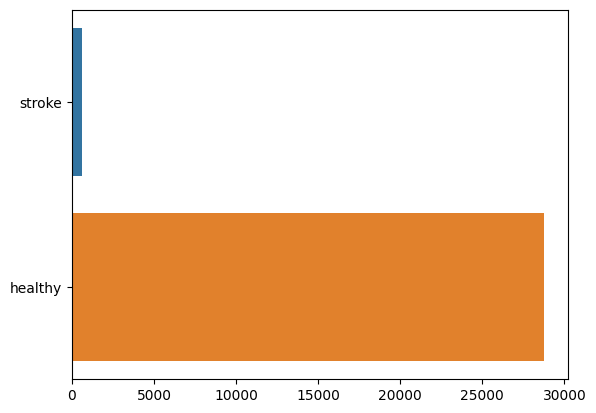

In [23]:
import seaborn

print("There are", num_stroke, "records are marked stroke.")
print("There are", num_healthy, "records are marked as healthy (non-stroke).")
seaborn.barplot(y=['stroke', 'healthy'], x=[num_stroke, num_healthy], orient='horizon')

#Do rebalance after data formmating and PCA and train,test split

In [24]:
transformedData.show(n=100)

+-----+------+----+------------+-------------+------------+-----------------+------+-------------+-----------+------------------+
|   id|gender| age|hypertension|heart_disease|ever_married|avg_glucose_level|stroke|work_type_new|   bmi_cate|smoking_status_new|
+-----+------+----+------------+-------------+------------+-----------------+------+-------------+-----------+------------------+
|30468|  Male|58.0|           1|            0|         Yes|            87.96|     0|      Private|      Obese|      never smoked|
|56543|Female|70.0|           0|            0|         Yes|            69.04|     0|      Private|      Obese|            smokes|
|52800|Female|52.0|           0|            0|         Yes|            77.59|     0|      Private|Underweight|            smokes|
|41413|Female|75.0|           0|            1|         Yes|           243.53|     0|      Private| Overweight|      never smoked|
|15266|Female|32.0|           0|            0|         Yes|            77.67|     0|      

Iteration 4 / 3.5 formatting data

In [25]:
#Gender Categories
formattedData = transformedData
formattedData = formattedData.withColumn("gender_num", formattedData["gender"])
formattedData = formattedData.withColumn("gender_num", when(formattedData.gender == "Male", "1") \
                                       .when(formattedData.gender == "Female", "3") \
                                       .when(formattedData.gender == "Other", "2"))
formattedData = formattedData.drop('gender')

#Marry Categories
formattedData = formattedData.withColumn("ever_married_num", formattedData["ever_married"])
formattedData = formattedData.withColumn("ever_married_num", when(formattedData.ever_married == "Yes", "0") \
                                       .when(formattedData.ever_married == "No", "1"))
formattedData = formattedData.drop('ever_married')

#work Categories
formattedData = formattedData.withColumn("work_type_num", formattedData["work_type_new"])
formattedData = formattedData.withColumn("work_type_num", when(formattedData.work_type_new == "Private", "2") \
                                       .when(formattedData.work_type_new == "Govt_job", "1") \
                                       .when(formattedData.work_type_new == "Never_worked", "0"))
formattedData = formattedData.drop('work_type_new')

#bmi Categories
formattedData = formattedData.withColumn("bmi_num", formattedData["bmi_cate"])
formattedData = formattedData.withColumn("bmi_num", when(formattedData.bmi_cate == "Underweight", "0") \
                                       .when(formattedData.bmi_cate == "Normal", "1") \
                                       .when(formattedData.bmi_cate == "Overweight", "2") \
                                       .when(formattedData.bmi_cate == "Obese", "3"))
formattedData = formattedData.drop('bmi_cate')

#smoking Categories
formattedData = formattedData.withColumn("smoking_status_num", formattedData["smoking_status_new"])
formattedData = formattedData.withColumn("smoking_status_num", when(formattedData.smoking_status_new == "smokes", "1") \
                                       .when(formattedData.smoking_status_new == "never smoked", "0"))
formattedData = formattedData.drop('smoking_status_new')
formattedData = formattedData.drop('id')

In [26]:
for c in formattedData.columns:
    formattedData = formattedData.withColumn(c,col(c).cast(DoubleType()))
formattedData.printSchema()

root
 |-- age: double (nullable = true)
 |-- hypertension: double (nullable = true)
 |-- heart_disease: double (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- stroke: double (nullable = true)
 |-- gender_num: double (nullable = true)
 |-- ever_married_num: double (nullable = true)
 |-- work_type_num: double (nullable = true)
 |-- bmi_num: double (nullable = true)
 |-- smoking_status_num: double (nullable = true)



1. PCA
2. re-balance
3. train test split
4. model train, eval, selection

Iteration 4 / 4.1 data reduction

In [27]:
# train,test = formattedData.randomSplit([0.7,0.3])
# train_x = train.drop('stroke')
# train_y = train.select('stroke')
# test_x = test.drop('stroke')
# test_y = test.select('stroke')

In [28]:
from pyspark.ml.feature import PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

In [29]:
assembler = VectorAssembler(inputCols=['age',
                             'hypertension',
                             'heart_disease',
                             'avg_glucose_level',
                             'bmi_num',
                             'gender_num',
                             'work_type_num',
                             'ever_married_num',
                             'smoking_status_num'],
                              outputCol="features")

finalData = assembler.transform(formattedData)
print("There are ", finalData.count(),"instances in the dataset.")

There are  29399 instances in the dataset.


In [82]:
train, test = finalData.randomSplit([0.8,0.2])
# training PCA model
pca = PCA(k=3, inputCol="features")
pca.setOutputCol("pca_features")
model = pca.fit(train)

In [83]:
model.explainedVariance

DenseVector([0.8524, 0.1466, 0.0004])

In [84]:
train_stroke = train.filter('stroke==1.0')
train_health = train.filter('stroke==0.0')
print("There are", train_stroke.count(), "marked as stroke.")
print("There are", train_health.count(), "marked as non-stroke.")
train_stroke_resample = train_stroke.sample(True, 50.0).limit(train_health.count())

oversampled = train_health.union(train_stroke_resample)
print("After rebalance, there are", oversampled.count(), "instances in training dataset")
print("After rebalance, there are", oversampled.filter('stroke==1.0').count(), "marked as stroke.")
print("After rebalance, there are",oversampled.filter('stroke==0.0').count(), "marked as non-stroke.")

There are 496 marked as stroke.
There are 23015 marked as non-stroke.
After rebalance, there are 46030 instances in training dataset


After rebalance, there are 23015 marked as stroke.


After rebalance, there are 23015 marked as non-stroke.


There are 23015 records are marked stroke.
There are 23015 records are marked as healthy (non-stroke).


<AxesSubplot:>

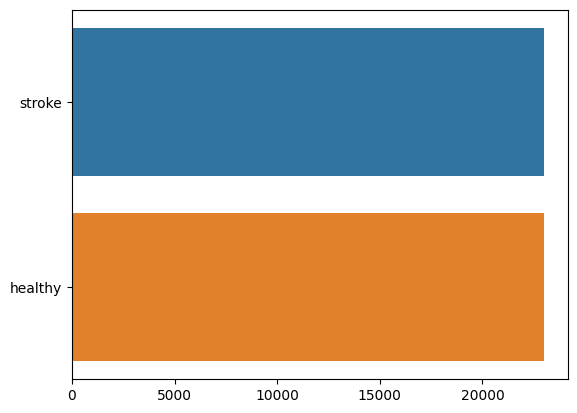

In [85]:
import seaborn
strokeData = oversampled.filter('stroke==1.0')
nonStrokeData = oversampled.filter('stroke==0')
num_stroke = strokeData.count()
num_healthy = nonStrokeData.count()
print("There are", num_stroke, "records are marked stroke.")
print("There are", num_healthy, "records are marked as healthy (non-stroke).")
seaborn.barplot(y=['stroke', 'healthy'], x=[num_stroke, num_healthy], orient='horizon')

There are 124 records are marked stroke.
There are 5764 records are marked as healthy (non-stroke).


<AxesSubplot:>

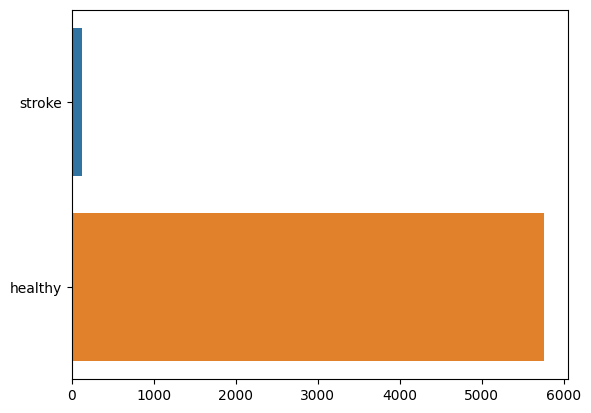

In [86]:
import seaborn
strokeData = test.filter('stroke==1.0')
nonStrokeData = test.filter('stroke==0')
num_stroke = strokeData.count()
num_healthy = nonStrokeData.count()
print("There are", num_stroke, "records are marked stroke.")
print("There are", num_healthy, "records are marked as healthy (non-stroke).")
seaborn.barplot(y=['stroke', 'healthy'], x=[num_stroke, num_healthy], orient='horizon')

Iteration 4 / 4.2 Data Projection

In [87]:
train_oversample_pca = model.transform(oversampled)
test_pca = model.transform(test)

In [88]:
train_oversample_pca = train_oversample_pca.select(['pca_features','stroke'])
test_pca = test_pca.select(['pca_features','stroke'])

In [89]:
test_pca.show()

+--------------------+------+
|        pca_features|stroke|
+--------------------+------+
|[-65.611384295286...|   0.0|
|[-72.875260562016...|   0.0|
|[-73.344545333055...|   0.0|
|[-85.446695821566...|   0.0|
|[-88.086238535219...|   0.0|
|[-89.089766841092...|   0.0|
|[-89.169236885308...|   0.0|
|[-95.427283869719...|   0.0|
|[-97.195711351176...|   0.0|
|[-101.62616631624...|   0.0|
|[-107.23120269477...|   0.0|
|[-123.02899436036...|   0.0|
|[-56.957038711078...|   0.0|
|[-65.492751967733...|   0.0|
|[-69.297380334598...|   0.0|
|[-69.674863044627...|   0.0|
|[-70.911664250157...|   0.0|
|[-72.347043281407...|   0.0|
|[-73.449690144911...|   0.0|
|[-73.646064279006...|   0.0|
+--------------------+------+
only showing top 20 rows



In [90]:
train_pca = model.transform(train).select(['pca_features','stroke'])

train_pca_health = train_pca.filter('stroke == 0.0')
train_pca_stroke = train_pca.filter('stroke == 1.0')

x_health = []
y_health = []
z_health = []

x_stroke = []
y_stroke = []
z_stroke = []

train_pca_health_pandas = train_pca_health.toPandas()
train_pca_stroke_pandas = train_pca_stroke.toPandas()

for row in train_pca_health_pandas.pca_features:
    x_health.append(row[0])
    y_health.append(row[1])
    z_health.append(row[2])
    
for row in train_pca_stroke_pandas.pca_features:
    x_stroke.append(row[0])
    y_stroke.append(row[1])
    z_stroke.append(row[2])

x_health = x_health[:500]
y_health = y_health[:500]
z_health = z_health[:500]

x_stroke = x_stroke[:100]
y_stroke = y_stroke[:100]
z_stroke = z_stroke[:100]

4.3 data visualization

/tmp/ipykernel_1328/1033223198.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


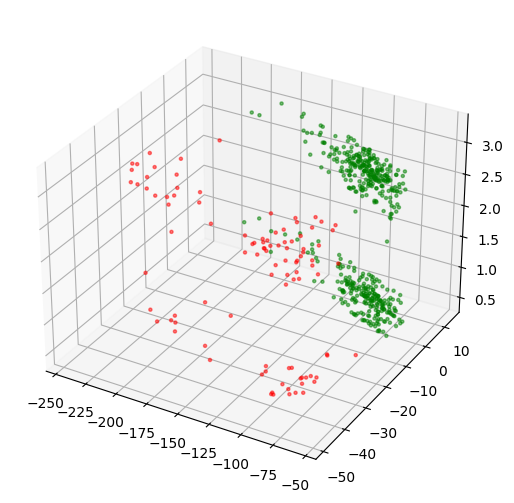

In [91]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 空间三维画图

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x_health, y_health, z_health, c='g', alpha=0.5, s=5)
ax.scatter(x_stroke, y_stroke, z_stroke, c='r', alpha=0.5, s=5)
# 添加坐标轴
# ax.set_xlabel('sepal length (cm)', fontdict={'size': 10, 'color': 'black'})
# ax.set_ylabel('sepal width (cm)', fontdict={'size': 10, 'color': 'black'})
# ax.set_zlabel('petal length (cm)', fontdict={'size': 10, 'color': 'black'})
plt.show()

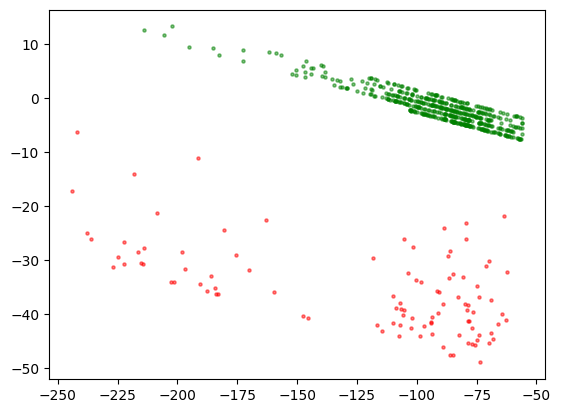

In [92]:
plt.scatter(x_health, y_health, c='g', alpha=0.5, s=5)
plt.scatter(x_stroke, y_stroke, c='r', alpha=0.5, s=5)
plt.show()

In [93]:
# final data is
print(train_oversample_pca.count())
print(test_pca.count())

46030
5888


Iteration 4 6.2 Model training

In [94]:
import time
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

print("Decision Tree")
start = time.time()
dtc = DecisionTreeClassifier(labelCol="stroke", featuresCol = "pca_features")
dtc_model = dtc.fit(train_oversample_pca)
dtc_predictions = dtc_model.transform(test_pca)
end = time.time()
print("Time Elapsed: ", end - start)

binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
print("Accuracy: ",binary_eval.evaluate(dtc_predictions))

tp = dtc_predictions[(dtc_predictions.prediction == 1) & (dtc_predictions.stroke == 1)].count()
tn = dtc_predictions[(dtc_predictions.prediction == 0) & (dtc_predictions.stroke == 0)].count()
fn = dtc_predictions[(dtc_predictions.prediction == 0) & (dtc_predictions.stroke == 1)].count()
fp = dtc_predictions[(dtc_predictions.prediction == 1) & (dtc_predictions.stroke == 0)].count()
    
print("Confusion Matrix")
print("[" + str(tp) + "  " + str(fp))
print(" " + str(fn) + "  " + str(tn) + "]" + "\n")

precision = float((tp)/(tp + fp))
recall = float((tp)/(tp + fn))

print("Precision: ",precision)
print("Recall: ",recall)
print("F1 :",float(2 * precision * recall / (precision + recall)))

Decision Tree


Time Elapsed:  6.470633506774902
Accuracy:  0.7897622338877571
Confusion Matrix
[112  2104
 12  3660]

Precision:  0.05054151624548736
Recall:  0.9032258064516129
F1 : 0.09572649572649573


In [95]:
from pyspark.ml.classification import RandomForestClassifier
print("Random Forest")
start = time.time()
rfc = RandomForestClassifier(labelCol="stroke", featuresCol = "pca_features")
rfc_model = rfc.fit(train_oversample_pca)
rfc_predictions = rfc_model.transform(test_pca)
end = time.time()
print("Time Elapsed: ", end - start)

binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
print("Accuracy: ",binary_eval.evaluate(rfc_predictions))

tp = rfc_predictions[(rfc_predictions.prediction == 1) & (rfc_predictions.stroke == 1)].count()
tn = rfc_predictions[(rfc_predictions.prediction == 0) & (rfc_predictions.stroke == 0)].count()
fn = rfc_predictions[(rfc_predictions.prediction == 0) & (rfc_predictions.stroke == 1)].count()
fp = rfc_predictions[(rfc_predictions.prediction == 1) & (rfc_predictions.stroke == 0)].count()
    
print("Confusion Matrix")
print("[" + str(tp) + "  " + str(fp))
print(" " + str(fn) + "  " + str(tn) + "]" + "\n")

precision = float((tp)/(tp + fp))
recall = float((tp)/(tp + fn))

print("Precision: ",precision)
print("Recall: ",recall)
print("F1 :",float(2 * precision * recall / (precision + recall)))

Random Forest


Time Elapsed:  8.359005451202393


Accuracy:  0.8364689899487375
Confusion Matrix
[107  1893
 17  3871]

Precision:  0.0535
Recall:  0.8629032258064516
F1 : 0.1007532956685499


In [96]:
from pyspark.ml.classification import LogisticRegression

print("Logistic Regression ---")
start = time.time()
lr = LogisticRegression(labelCol="stroke", featuresCol = "pca_features")
lr_model = lr.fit(train_oversample_pca)
lr_predictions = lr_model.transform(test_pca)
end = time.time()
print("Time Elapsed: ", end - start)

binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
print("Accuracy: ",binary_eval.evaluate(lr_predictions))

tp = lr_predictions[(lr_predictions.prediction == 1) & (lr_predictions.stroke == 1)].count()
tn = lr_predictions[(lr_predictions.prediction == 0) & (lr_predictions.stroke == 0)].count()
fn = lr_predictions[(lr_predictions.prediction == 0) & (lr_predictions.stroke == 1)].count()
fp = lr_predictions[(lr_predictions.prediction == 1) & (lr_predictions.stroke == 0)].count()
    
print("Confusion Matrix")
print("[" + str(tp) + "  " + str(fp))
print(" " + str(fn) + "  " + str(tn) + "]" + "\n")

precision = float((tp)/(tp + fp))
recall = float((tp)/(tp + fn))

print("Precision: ",precision)
print("Recall: ",recall)
print("F1 :",float(2 * precision * recall / (precision + recall)))

Logistic Regression ---


Time Elapsed:  5.032065391540527


Accuracy:  0.8416114481430937
Confusion Matrix
[105  1763
 19  4001]

Precision:  0.05620985010706638
Recall:  0.8467741935483871
F1 : 0.10542168674698796


In [97]:
from pyspark.ml.classification import LinearSVC

print("Linear SVM ---")
start = time.time()
svm = LinearSVC(labelCol="stroke", featuresCol = "pca_features")
svm_model = svm.fit(train_oversample_pca)
svm_predictions = svm_model.transform(test_pca)
end = time.time()
print("Time Elapsed: ", end - start)

binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
print("Accuracy: ",binary_eval.evaluate(svm_predictions))

tp = svm_predictions[(svm_predictions.prediction == 1) & (svm_predictions.stroke == 1)].count()
tn = svm_predictions[(svm_predictions.prediction == 0) & (svm_predictions.stroke == 0)].count()
fn = svm_predictions[(svm_predictions.prediction == 0) & (svm_predictions.stroke == 1)].count()
fp = svm_predictions[(svm_predictions.prediction == 1) & (svm_predictions.stroke == 0)].count()
    
print("Confusion Matrix")
print("[" + str(tp) + "  " + str(fp))
print(" " + str(fn) + "  " + str(tn) + "]" + "\n")

precision = float((tp)/(tp + fp))
recall = float((tp)/(tp + fn))

print("Precision: ",precision)
print("Recall: ",recall)
print("F1 :",float(2 * precision * recall / (precision + recall)))

Linear SVM ---


22/10/16 01:55:21 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


Time Elapsed:  11.38164496421814
Accuracy:  0.841836706140452
Confusion Matrix
[108  1835
 16  3929]

Precision:  0.055584148224395266
Recall:  0.8709677419354839
F1 : 0.10449927431059507


In [98]:

rfc = RandomForestClassifier(labelCol="stroke", featuresCol = "features")
rfc_model = rfc.fit(train)
rfc_predictions = rfc_model.transform(test)
print(rfc_model.featureImportances)
#train.printSchema()
#train.columns

for i in range(9):
    print(train.columns[i], rfc_model.featureImportances[i])

(9,[0,1,2,3,4,5,6,7,8],[0.555554031914557,0.11965801689364586,0.12653768394842635,0.04605057892910389,0.025307030316007752,0.0008777288235775946,0.005042472690163936,0.1049103174048371,0.01606213907968061])
age 0.555554031914557
hypertension 0.11965801689364586
heart_disease 0.12653768394842635
avg_glucose_level 0.04605057892910389
stroke 0.025307030316007752
gender_num 0.0008777288235775946
ever_married_num 0.005042472690163936
work_type_num 0.1049103174048371
bmi_num 0.01606213907968061


In [99]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
print("Neural network  ---------  Final model")
start = time.time()
mlp = MultilayerPerceptronClassifier(labelCol="stroke", featuresCol = "pca_features", 
                                     maxIter=100, layers=[3, 16, 32, 2], stepSize=0.5)
mlp_model = mlp.fit(train_oversample_pca)
mlp_predictions = mlp_model.transform(test_pca)
end = time.time()
print("Time Elapsed: ", end - start)

binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
print("Accuracy: ",binary_eval.evaluate(mlp_predictions))

tp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 1)].count()
tn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 0)].count()
fn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 1)].count()
fp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 0)].count()
    
print("Confusion Matrix")
print("[" + str(tp) + "  " + str(fp))
print(" " + str(fn) + "  " + str(tn) + "]" + "\n")

precision = float((tp)/(tp + fp))
recall = float((tp)/(tp + fn))

print("Precision: ",precision)
print("Recall: ",recall)
print("F1 :",float(2 * precision * recall / (precision + recall)))

Neural network  ---------  Final model


Time Elapsed:  25.359779357910156
Accuracy:  0.8358638714154626
Confusion Matrix
[107  1905
 17  3859]

Precision:  0.053180914512922464
Recall:  0.8629032258064516
F1 : 0.10018726591760299


In [100]:
summary = mlp_model.summary()
summary.accuracy

0.7398653052357158

6.2 Model tuning

In [47]:
maxIter=[100, 300]
stepSize=[0.5, 0.1]
layers=[[3, 8, 2], 
       [3, 32, 2],
       [3, 8, 32, 2],
       [3, 16, 32, 2],
       [3, 16, 32, 8, 2]]

best = 0
best_mi = 0
best_ss = 0
best_ly = 0
for mi in maxIter:
    for ss in stepSize:
        for ly in layers:
            print("Neural network -",'max_iter=',mi,'layers=',ly, 'step_size=',ss)
            start = time.time()
            mlp = MultilayerPerceptronClassifier(labelCol="stroke", featuresCol = "pca_features", maxIter=mi, layers=ly, stepSize=ss)
            mlp_model = mlp.fit(train_oversample_pca)
            mlp_predictions = mlp_model.transform(test_pca)
            end = time.time()

            binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
            accuracy = binary_eval.evaluate(mlp_predictions)

            tp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 1)].count()
            tn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 0)].count()
            fn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 1)].count()
            fp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 0)].count()

            recall = float((tp)/(tp + fn))
            print("Accuracy: ",accuracy,"Recall: ",recall)
            acc_rec = accuracy + recall
            if acc_rec > best:
                best = acc_rec
                best_mi = mi
                best_ss = ss
                best_ly = ly

print('Best paramerters for MLP is:\n', 'max_iter=',best_mi,'layers=',best_ly, 'step_size=',best_ss)

Neural network - max_iter= 100 layers= [3, 8, 2] step_size= 0.5


Accuracy:  0.6448939104862128 Recall:  0.3684210526315789
Neural network - max_iter= 100 layers= [3, 32, 2] step_size= 0.5


Accuracy:  0.808357739187497 Recall:  0.7894736842105263
Neural network - max_iter= 100 layers= [3, 8, 32, 2] step_size= 0.5


Accuracy:  0.6315327686568073 Recall:  0.35789473684210527
Neural network - max_iter= 100 layers= [3, 16, 32, 2] step_size= 0.5


Accuracy:  0.8134094471922091 Recall:  0.7947368421052632
Neural network - max_iter= 100 layers= [3, 16, 32, 8, 2] step_size= 0.5
Accuracy:  0.7803849846273501 Recall:  0.7473684210526316
Neural network - max_iter= 100 layers= [3, 8, 2] step_size= 0.1


Accuracy:  0.6448939104862128 Recall:  0.3684210526315789
Neural network - max_iter= 100 layers= [3, 32, 2] step_size= 0.1
Accuracy:  0.808357739187497 Recall:  0.7894736842105263
Neural network - max_iter= 100 layers= [3, 8, 32, 2] step_size= 0.1


Accuracy:  0.6315327686568073 Recall:  0.35789473684210527
Neural network - max_iter= 100 layers= [3, 16, 32, 2] step_size= 0.1
Accuracy:  0.8134094471922091 Recall:  0.7947368421052632
Neural network - max_iter= 100 layers= [3, 16, 32, 8, 2] step_size= 0.1
Accuracy:  0.7803849846273501 Recall:  0.7473684210526316
Neural network - max_iter= 300 layers= [3, 8, 2] step_size= 0.5
Accuracy:  0.6433463160325193 Recall:  0.3684210526315789
Neural network - max_iter= 300 layers= [3, 32, 2] step_size= 0.5
Accuracy:  0.8139623765023271 Recall:  0.7736842105263158
Neural network - max_iter= 300 layers= [3, 8, 32, 2] step_size= 0.5


Accuracy:  0.6310579178261979 Recall:  0.35789473684210527
Neural network - max_iter= 300 layers= [3, 16, 32, 2] step_size= 0.5
Accuracy:  0.8141233943783439 Recall:  0.7789473684210526
Neural network - max_iter= 300 layers= [3, 16, 32, 8, 2] step_size= 0.5
Accuracy:  0.8151356803460965 Recall:  0.7736842105263158
Neural network - max_iter= 300 layers= [3, 8, 2] step_size= 0.1
Accuracy:  0.6433463160325193 Recall:  0.3684210526315789
Neural network - max_iter= 300 layers= [3, 32, 2] step_size= 0.1
Accuracy:  0.8139623765023271 Recall:  0.7736842105263158
Neural network - max_iter= 300 layers= [3, 8, 32, 2] step_size= 0.1
Accuracy:  0.6310579178261979 Recall:  0.35789473684210527
Neural network - max_iter= 300 layers= [3, 16, 32, 2] step_size= 0.1
Accuracy:  0.8141233943783439 Recall:  0.7789473684210526
Neural network - max_iter= 300 layers= [3, 16, 32, 8, 2] step_size= 0.1
Accuracy:  0.8151356803460965 Recall:  0.7736842105263158
Best paramerters for MLP is:
 max_iter= 100 layers= [3,

In [48]:
maxIter=[100, 300, 500, 1000, 2000, 5000]
stepSize=[0.5, 0.1, 0.05, 0.01, 0.001]
layers=[[3, 8, 2]]

best = 0
best_mi = 0
best_ss = 0
best_ly = 0
for mi in maxIter:
    for ss in stepSize:
        for ly in layers:
            print("Neural network -",'max_iter=',mi,'layers=',ly, 'step_size=',ss)
            start = time.time()
            mlp = MultilayerPerceptronClassifier(labelCol="stroke", featuresCol = "pca_features", maxIter=mi, layers=ly, stepSize=ss)
            mlp_model = mlp.fit(train_oversample_pca)
            mlp_predictions = mlp_model.transform(test_pca)
            end = time.time()

            binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
            accuracy = binary_eval.evaluate(mlp_predictions)

            tp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 1)].count()
            tn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 0)].count()
            fn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 1)].count()
            fp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 0)].count()

            recall = float((tp)/(tp + fn))
            print("Accuracy: ",accuracy,"Recall: ",recall)
            acc_rec = accuracy + recall
            if acc_rec > best:
                best = acc_rec
                best_mi = mi
                best_ss = ss
                best_ly = ly

print('Best paramerters for MLP is:\n', 'max_iter=',best_mi,'layers=',best_ly, 'step_size=',best_ss)

Neural network - max_iter= 100 layers= [3, 8, 2] step_size= 0.5
Accuracy:  0.6448939104862128 Recall:  0.3684210526315789
Neural network - max_iter= 100 layers= [3, 8, 2] step_size= 0.1
Accuracy:  0.6448939104862128 Recall:  0.3684210526315789
Neural network - max_iter= 100 layers= [3, 8, 2] step_size= 0.05
Accuracy:  0.6448939104862128 Recall:  0.3684210526315789
Neural network - max_iter= 100 layers= [3, 8, 2] step_size= 0.01
Accuracy:  0.6448939104862128 Recall:  0.3684210526315789
Neural network - max_iter= 100 layers= [3, 8, 2] step_size= 0.001
Accuracy:  0.6448939104862128 Recall:  0.3684210526315789
Neural network - max_iter= 300 layers= [3, 8, 2] step_size= 0.5
Accuracy:  0.6433463160325193 Recall:  0.3684210526315789
Neural network - max_iter= 300 layers= [3, 8, 2] step_size= 0.1
Accuracy:  0.6433463160325193 Recall:  0.3684210526315789
Neural network - max_iter= 300 layers= [3, 8, 2] step_size= 0.05
Accuracy:  0.6433463160325193 Recall:  0.3684210526315789
Neural network - ma

Accuracy:  0.6433463160325193 Recall:  0.3684210526315789
Neural network - max_iter= 500 layers= [3, 8, 2] step_size= 0.05
Accuracy:  0.6433463160325193 Recall:  0.3684210526315789
Neural network - max_iter= 500 layers= [3, 8, 2] step_size= 0.01
Accuracy:  0.6433463160325193 Recall:  0.3684210526315789
Neural network - max_iter= 500 layers= [3, 8, 2] step_size= 0.001
Accuracy:  0.6433463160325193 Recall:  0.3684210526315789
Neural network - max_iter= 1000 layers= [3, 8, 2] step_size= 0.5
Accuracy:  0.6433463160325193 Recall:  0.3684210526315789
Neural network - max_iter= 1000 layers= [3, 8, 2] step_size= 0.1
Accuracy:  0.6433463160325193 Recall:  0.3684210526315789
Neural network - max_iter= 1000 layers= [3, 8, 2] step_size= 0.05
Accuracy:  0.6433463160325193 Recall:  0.3684210526315789
Neural network - max_iter= 1000 layers= [3, 8, 2] step_size= 0.01
Accuracy:  0.6433463160325193 Recall:  0.3684210526315789
Neural network - max_iter= 1000 layers= [3, 8, 2] step_size= 0.001
Accuracy:  

In [49]:
maxIter=[100, 300, 500, 1000, 2000, 5000]
stepSize=[0.5, 0.1, 0.05, 0.01, 0.001]
layers=[[3, 32, 2]]

best = 0
best_mi = 0
best_ss = 0
best_ly = 0
for mi in maxIter:
    for ss in stepSize:
        for ly in layers:
            print("Neural network -",'max_iter=',mi,'layers=',ly, 'step_size=',ss)
            start = time.time()
            mlp = MultilayerPerceptronClassifier(labelCol="stroke", featuresCol = "pca_features", maxIter=mi, layers=ly, stepSize=ss)
            mlp_model = mlp.fit(train_oversample_pca)
            mlp_predictions = mlp_model.transform(test_pca)
            end = time.time()

            binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
            accuracy = binary_eval.evaluate(mlp_predictions)

            tp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 1)].count()
            tn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 0)].count()
            fn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 1)].count()
            fp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 0)].count()

            recall = float((tp)/(tp + fn))
            print("Accuracy: ",accuracy,"Recall: ",recall)
            acc_rec = accuracy + recall
            if acc_rec > best:
                best = acc_rec
                best_mi = mi
                best_ss = ss
                best_ly = ly

print('Best paramerters for MLP is:\n', 'max_iter=',best_mi,'layers=',best_ly, 'step_size=',best_ss)

Neural network - max_iter= 100 layers= [3, 32, 2] step_size= 0.5


Accuracy:  0.808357739187497 Recall:  0.7894736842105263
Neural network - max_iter= 100 layers= [3, 32, 2] step_size= 0.1
Accuracy:  0.808357739187497 Recall:  0.7894736842105263
Neural network - max_iter= 100 layers= [3, 32, 2] step_size= 0.05
Accuracy:  0.808357739187497 Recall:  0.7894736842105263
Neural network - max_iter= 100 layers= [3, 32, 2] step_size= 0.01
Accuracy:  0.808357739187497 Recall:  0.7894736842105263
Neural network - max_iter= 100 layers= [3, 32, 2] step_size= 0.001
Accuracy:  0.808357739187497 Recall:  0.7894736842105263
Neural network - max_iter= 300 layers= [3, 32, 2] step_size= 0.5
Accuracy:  0.8139623765023271 Recall:  0.7736842105263158
Neural network - max_iter= 300 layers= [3, 32, 2] step_size= 0.1
Accuracy:  0.8139623765023271 Recall:  0.7736842105263158
Neural network - max_iter= 300 layers= [3, 32, 2] step_size= 0.05
Accuracy:  0.8139623765023271 Recall:  0.7736842105263158
Neural network - max_iter= 300 layers= [3, 32, 2] step_size= 0.01
Accuracy:  0.81

Accuracy:  0.8139623765023271 Recall:  0.7736842105263158
Neural network - max_iter= 500 layers= [3, 32, 2] step_size= 0.5


Accuracy:  0.8166316275565348 Recall:  0.7684210526315789
Neural network - max_iter= 500 layers= [3, 32, 2] step_size= 0.1
Accuracy:  0.8166316275565348 Recall:  0.7684210526315789
Neural network - max_iter= 500 layers= [3, 32, 2] step_size= 0.05
Accuracy:  0.8166316275565348 Recall:  0.7684210526315789
Neural network - max_iter= 500 layers= [3, 32, 2] step_size= 0.01
Accuracy:  0.8166316275565348 Recall:  0.7684210526315789
Neural network - max_iter= 500 layers= [3, 32, 2] step_size= 0.001
Accuracy:  0.8166316275565348 Recall:  0.7684210526315789
Neural network - max_iter= 1000 layers= [3, 32, 2] step_size= 0.5
Accuracy:  0.8146489810302698 Recall:  0.7631578947368421
Neural network - max_iter= 1000 layers= [3, 32, 2] step_size= 0.1
Accuracy:  0.8146489810302698 Recall:  0.7631578947368421
Neural network - max_iter= 1000 layers= [3, 32, 2] step_size= 0.05
Accuracy:  0.8146489810302698 Recall:  0.7631578947368421
Neural network - max_iter= 1000 layers= [3, 32, 2] step_size= 0.01
Accura

22/10/15 13:53:19 WARN BlockManager: Asked to remove block broadcast_93076, which does not exist


Accuracy:  0.8023551142923017 Recall:  0.7842105263157895
Neural network - max_iter= 5000 layers= [3, 32, 2] step_size= 0.01
Accuracy:  0.8023551142923017 Recall:  0.7842105263157895
Neural network - max_iter= 5000 layers= [3, 32, 2] step_size= 0.001
Accuracy:  0.8023551142923017 Recall:  0.7842105263157895
Best paramerters for MLP is:
 max_iter= 100 layers= [3, 32, 2] step_size= 0.5


In [50]:
maxIter=[100, 300, 500, 1000, 2000, 5000]
stepSize=[0.5, 0.1, 0.05, 0.01, 0.001]
layers=[[3, 8, 32, 2]]

best = 0
best_mi = 0
best_ss = 0
best_ly = 0
for mi in maxIter:
    for ss in stepSize:
        for ly in layers:
            print("Neural network -",'max_iter=',mi,'layers=',ly, 'step_size=',ss)
            start = time.time()
            mlp = MultilayerPerceptronClassifier(labelCol="stroke", featuresCol = "pca_features", maxIter=mi, layers=ly, stepSize=ss)
            mlp_model = mlp.fit(train_oversample_pca)
            mlp_predictions = mlp_model.transform(test_pca)
            end = time.time()

            binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
            accuracy = binary_eval.evaluate(mlp_predictions)

            tp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 1)].count()
            tn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 0)].count()
            fn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 1)].count()
            fp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 0)].count()

            recall = float((tp)/(tp + fn))
            print("Accuracy: ",accuracy,"Recall: ",recall)
            acc_rec = accuracy + recall
            if acc_rec > best:
                best = acc_rec
                best_mi = mi
                best_ss = ss
                best_ly = ly

print('Best paramerters for MLP is:\n', 'max_iter=',best_mi,'layers=',best_ly, 'step_size=',best_ss)

Neural network - max_iter= 100 layers= [3, 8, 32, 2] step_size= 0.5
Accuracy:  0.6315327686568073 Recall:  0.35789473684210527
Neural network - max_iter= 100 layers= [3, 8, 32, 2] step_size= 0.1
Accuracy:  0.6315327686568073 Recall:  0.35789473684210527
Neural network - max_iter= 100 layers= [3, 8, 32, 2] step_size= 0.05
Accuracy:  0.6315327686568073 Recall:  0.35789473684210527
Neural network - max_iter= 100 layers= [3, 8, 32, 2] step_size= 0.01
Accuracy:  0.6315327686568073 Recall:  0.35789473684210527
Neural network - max_iter= 100 layers= [3, 8, 32, 2] step_size= 0.001
Accuracy:  0.6315327686568073 Recall:  0.35789473684210527
Neural network - max_iter= 300 layers= [3, 8, 32, 2] step_size= 0.5
Accuracy:  0.6310579178261979 Recall:  0.35789473684210527
Neural network - max_iter= 300 layers= [3, 8, 32, 2] step_size= 0.1
Accuracy:  0.6310579178261979 Recall:  0.35789473684210527
Neural network - max_iter= 300 layers= [3, 8, 32, 2] step_size= 0.05
Accuracy:  0.6310579178261979 Recall: 

22/10/15 14:22:54 WARN BlockManager: Asked to remove block broadcast_133364, which does not exist


Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 500 layers= [3, 8, 32, 2] step_size= 0.1


Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 500 layers= [3, 8, 32, 2] step_size= 0.05


22/10/15 14:25:01 WARN BlockManager: Asked to remove block broadcast_135372, which does not exist


Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 500 layers= [3, 8, 32, 2] step_size= 0.01


22/10/15 14:26:10 WARN BlockManager: Asked to remove block broadcast_136506, which does not exist


Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 500 layers= [3, 8, 32, 2] step_size= 0.001
Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 1000 layers= [3, 8, 32, 2] step_size= 0.5
Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 1000 layers= [3, 8, 32, 2] step_size= 0.1


Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 1000 layers= [3, 8, 32, 2] step_size= 0.05
Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 1000 layers= [3, 8, 32, 2] step_size= 0.01
Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 1000 layers= [3, 8, 32, 2] step_size= 0.001
Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 2000 layers= [3, 8, 32, 2] step_size= 0.5
Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 2000 layers= [3, 8, 32, 2] step_size= 0.1
Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 2000 layers= [3, 8, 32, 2] step_size= 0.05
Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 2000 layers= [3, 8, 32, 2] step_size= 0.01


Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 2000 layers= [3, 8, 32, 2] step_size= 0.001
Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 5000 layers= [3, 8, 32, 2] step_size= 0.5
Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 5000 layers= [3, 8, 32, 2] step_size= 0.1
Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 5000 layers= [3, 8, 32, 2] step_size= 0.05


22/10/15 14:40:38 WARN BlockManager: Asked to remove block broadcast_150308, which does not exist


Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 5000 layers= [3, 8, 32, 2] step_size= 0.01
Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Neural network - max_iter= 5000 layers= [3, 8, 32, 2] step_size= 0.001


22/10/15 14:42:36 WARN BlockManager: Asked to remove block broadcast_152134, which does not exist


Accuracy:  0.6321103063592947 Recall:  0.35789473684210527
Best paramerters for MLP is:
 max_iter= 500 layers= [3, 8, 32, 2] step_size= 0.5


In [ ]:
maxIter=[100, 300, 500, 1000, 2000, 5000]
stepSize=[0.5, 0.1, 0.05, 0.01, 0.001]
layers=[[3, 16, 32, 8, 2]]

best = 0
best_mi = 0
best_ss = 0
best_ly = 0
for mi in maxIter:
    for ss in stepSize:
        for ly in layers:
            print("Neural network -",'max_iter=',mi,'layers=',ly, 'step_size=',ss)
            start = time.time()
            mlp = MultilayerPerceptronClassifier(labelCol="stroke", featuresCol = "pca_features", maxIter=mi, layers=ly, stepSize=ss)
            mlp_model = mlp.fit(train_oversample_pca)
            mlp_predictions = mlp_model.transform(test_pca)
            end = time.time()

            binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
            accuracy = binary_eval.evaluate(mlp_predictions)

            tp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 1)].count()
            tn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 0)].count()
            fn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 1)].count()
            fp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 0)].count()

            recall = float((tp)/(tp + fn))
            print("Accuracy: ",accuracy,"Recall: ",recall)
            acc_rec = accuracy + recall
            if acc_rec > best:
                best = acc_rec
                best_mi = mi
                best_ss = ss
                best_ly = ly

print('Best paramerters for MLP is:\n', 'max_iter=',best_mi,'layers=',best_ly, 'step_size=',best_ss)

Neural network - max_iter= 100 layers= [3, 16, 32, 8, 2] step_size= 0.5
Accuracy:  0.7803849846273501 Recall:  0.7473684210526316
Neural network - max_iter= 100 layers= [3, 16, 32, 8, 2] step_size= 0.1
Accuracy:  0.7803849846273501 Recall:  0.7473684210526316
Neural network - max_iter= 100 layers= [3, 16, 32, 8, 2] step_size= 0.05
Accuracy:  0.7803849846273501 Recall:  0.7473684210526316
Neural network - max_iter= 100 layers= [3, 16, 32, 8, 2] step_size= 0.01
Accuracy:  0.7803849846273501 Recall:  0.7473684210526316
Neural network - max_iter= 100 layers= [3, 16, 32, 8, 2] step_size= 0.001
Accuracy:  0.7803849846273501 Recall:  0.7473684210526316
Neural network - max_iter= 300 layers= [3, 16, 32, 8, 2] step_size= 0.5
Accuracy:  0.8151356803460965 Recall:  0.7736842105263158
Neural network - max_iter= 300 layers= [3, 16, 32, 8, 2] step_size= 0.1
Accuracy:  0.8151356803460965 Recall:  0.7736842105263158
Neural network - max_iter= 300 layers= [3, 16, 32, 8, 2] step_size= 0.05
Accuracy:  0.

22/10/15 15:00:30 WARN BlockManager: Asked to remove block broadcast_166334, which does not exist


Accuracy:  0.8146981978150171 Recall:  0.7684210526315789
Neural network - max_iter= 1000 layers= [3, 16, 32, 8, 2] step_size= 0.1
Accuracy:  0.8146981978150171 Recall:  0.7684210526315789
Neural network - max_iter= 1000 layers= [3, 16, 32, 8, 2] step_size= 0.05
Accuracy:  0.8146981978150171 Recall:  0.7684210526315789
Neural network - max_iter= 1000 layers= [3, 16, 32, 8, 2] step_size= 0.01
Accuracy:  0.8146981978150171 Recall:  0.7684210526315789
Neural network - max_iter= 1000 layers= [3, 16, 32, 8, 2] step_size= 0.001
Accuracy:  0.8146981978150171 Recall:  0.7684210526315789
Neural network - max_iter= 2000 layers= [3, 16, 32, 8, 2] step_size= 0.5
Accuracy:  0.8120344152924444 Recall:  0.7578947368421053
Neural network - max_iter= 2000 layers= [3, 16, 32, 8, 2] step_size= 0.1
Accuracy:  0.8120344152924444 Recall:  0.7578947368421053
Neural network - max_iter= 2000 layers= [3, 16, 32, 8, 2] step_size= 0.05


Accuracy:  0.8120344152924444 Recall:  0.7578947368421053
Neural network - max_iter= 2000 layers= [3, 16, 32, 8, 2] step_size= 0.01
Accuracy:  0.8120344152924444 Recall:  0.7578947368421053
Neural network - max_iter= 2000 layers= [3, 16, 32, 8, 2] step_size= 0.001


22/10/15 15:45:16 WARN BlockManager: Asked to remove block broadcast_201264, which does not exist


Accuracy:  0.8120344152924444 Recall:  0.7578947368421053
Neural network - max_iter= 5000 layers= [3, 16, 32, 8, 2] step_size= 0.5


22/10/15 16:04:09 WARN BlockManager: Asked to remove block broadcast_215092, which does not exist


Accuracy:  0.7900533485642051 Recall:  0.7894736842105263
Neural network - max_iter= 5000 layers= [3, 16, 32, 8, 2] step_size= 0.1


22/10/15 16:09:11 WARN BlockManager: Asked to remove block broadcast_218724, which does not exist


In [ ]:
maxIter=[100, 300, 500, 1000, 2000, 5000]
stepSize=[0.5, 0.1, 0.05, 0.01, 0.001]
layers=[[3, 8, 2], 
       [3, 32, 2],
       [3, 8, 32, 2],
       [3, 16, 32, 8, 2],
       [3, 32, 64, 16, 2]]

best = 0
best_mi = 0
best_ss = 0
best_ly = 0
for mi in maxIter:
    for ss in stepSize:
        for ly in layers:
            print("Neural network -",'max_iter=',mi,'layers=',ly, 'step_size=',ss)
            start = time.time()
            mlp = MultilayerPerceptronClassifier(labelCol="stroke", featuresCol = "pca_features", maxIter=mi, layers=ly, stepSize=ss)
            mlp_model = mlp.fit(train_oversample_pca)
            mlp_predictions = mlp_model.transform(test_pca)
            end = time.time()

            binary_eval = BinaryClassificationEvaluator(labelCol = 'stroke')
            accuracy = binary_eval.evaluate(mlp_predictions)

            tp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 1)].count()
            tn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 0)].count()
            fn = mlp_predictions[(mlp_predictions.prediction == 0) & (mlp_predictions.stroke == 1)].count()
            fp = mlp_predictions[(mlp_predictions.prediction == 1) & (mlp_predictions.stroke == 0)].count()

            recall = float((tp)/(tp + fn))
            print("Accuracy: ",accuracy,"Recall: ",recall)
            acc_rec = accuracy + recall
            if acc_rec > best:
                best = acc_rec
                best_mi = mi
                best_ss = ss
                best_ly = ly

print('Best paramerters for MLP is:\n', 'max_iter=',best_mi,'layers=',best_ly, 'step_size=',best_ss)